# Installing Dependencies




In [ ]:
%%capture
!pip install ta
!pip install yfinance
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib
!pip install pandas_datareader
!pip install backtesting

In [ ]:
import yfinance as yf
import ta as ta
import numpy as np
import pandas as pd
import talib
import scipy.stats as stats
import statsmodels.api as sm
import numba as nb
#import numpy_ext as npx
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb

# Importing Dataset

In [ ]:
TICKER = "^GSPC"

data=yf.Ticker(TICKER).history(start="1982-04-20", end="2023-01-10")
#data=yf.Ticker(TICKER).history(period = 'max')
data['Close_lag'] = data['Close'].shift(-1)
data["Percent_Returns"]=(data["Close_lag"]-data["Close"])/data["Close"]

vix = yf.Ticker('^VIX').history(period = 'max')
notional_signal=[]

for i in data["Percent_Returns"]:
  
  if i > 0 :
    notional_signal.append(1)
  #elif i <= -0.005:
  #  notional_signal.append(-1)
  else:
    notional_signal.append(0)

data["Signal"]= notional_signal

#data['Signal'] = data['Notional_Signal'].shift(-1).gt(0).astype(int)

#data['log_return'] = np.log(data['Close']).diff()
#data['Signal'] = data['log_return'].gt(0).astype(int)
data.head()
vix.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1990-01-02 00:00:00-05:00,17.240000,17.240000,17.240000,17.240000,0,0.0,0.0
1990-01-03 00:00:00-05:00,18.190001,18.190001,18.190001,18.190001,0,0.0,0.0
1990-01-04 00:00:00-05:00,19.219999,19.219999,19.219999,19.219999,0,0.0,0.0
1990-01-05 00:00:00-05:00,20.110001,20.110001,20.110001,20.110001,0,0.0,0.0
1990-01-08 00:00:00-05:00,20.260000,20.260000,20.260000,20.260000,0,0.0,0.0


In [ ]:
data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Close_lag,Percent_Returns,Signal
Date,,,,,,,,,,
1982-04-20 00:00:00-05:00,115.800003,117.139999,114.830002,115.440002,54610000,0.0,0.0,115.720001,0.002425,1
1982-04-21 00:00:00-05:00,115.480003,115.870003,115.300003,115.720001,57820000,0.0,0.0,117.190002,0.012703,1
1982-04-22 00:00:00-05:00,115.720001,117.250000,115.720001,117.190002,64470000,0.0,0.0,118.639999,0.012373,1
1982-04-23 00:00:00-05:00,118.019997,118.639999,117.190002,118.639999,71840000,0.0,0.0,119.260002,0.005226,1
1982-04-26 00:00:00-04:00,118.940002,119.330002,118.250000,119.260002,60500000,0.0,0.0,118.000000,-0.010565,0


# Creating Technical Indicator Functions Using Ta-Lib

## Volatility

In [ ]:
data['long_vol'] = data['Percent_Returns'].rolling(100).std()*(252*0.5)
data['long_vol_delta'] = data['long_vol'].diff().rolling(20).mean()
data['short_vol'] = data['Percent_Returns'].rolling(25).std()*(252*0.5)
data['short_vol_delta'] = data['long_vol'].diff().rolling(5).mean()
data['short_long_vol_delta'] = data['short_vol'] - data['long_vol']
data['MA12'] = data['Percent_Returns'].rolling(12).mean()

## ADXR

In [ ]:
def adxr_strategy(data, n=14, adxr_threshold = 25):
    """
    data: pandas DataFrame containing 'High', 'Low' and 'Close' columns
    n: the period for ADXR
    adxr_threshold: ADXR value threshold to generate trading signals
    """
    # Calculate ADXR
    high = data['High'].values
    low = data['Low'].values
    close = data['Close'].values
    adxr = talib.ADXR(high, low, close, timeperiod=n)
    # Add ADXR as a new column in the DataFrame
    data['ADXR'] = adxr
    
    # Generate trading signals based on ADXR
    data['ADXR_Position'] = np.where(data['ADXR'] > adxr_threshold, 1, 0)
    return data

In [ ]:
data = adxr_strategy(data)
#data.head()

## MACD

In [ ]:
def macd_strategy(data, fast_period=12, slow_period=26, signal_period=9):
    """
    data: pandas DataFrame containing 'Close' column
    fast_period: the fast period for MACD
    slow_period: the slow period for MACD
    signal_period: the signal period for MACD
    """
    # Calculate MACD
    macd, macd_signal, macd_hist = talib.MACD(data['Close'].values, 
                                              fastperiod=fast_period, 
                                              slowperiod=slow_period, 
                                              signalperiod=signal_period)
    # Add MACD as new columns in the DataFrame
    data['MACD'] = macd
    data['MACD_Signal'] = macd_signal
    data['MACD_Hist'] = macd_hist
    # Calculate the first order difference of macd_hist
    data['macd_hist_diff'] = data['MACD_Hist'].diff().pct_change()
    # Generate trading signals based on macd divergence
    data['MACD_Hist_Position'] = np.where(data['MACD_Hist']>0, 1, 0)
    data['MACD_Hist_diff_Postion'] = np.where(data['macd_hist_diff']> 0, 1, 0 )

    data['MACD_Position'] = np.where((data['macd_hist_diff'] > 0) & (data['MACD_Hist'] < 0), 1,
                               np.where((data['macd_hist_diff'] < 0) & (data['MACD_Hist'] > 0), -1, 0))
    return data

In [ ]:
data = macd_strategy(data)
#data.tail()

## RSI

In [ ]:
def rsi_strategy(data, n=14, range =30):
    """
    data: pandas DataFrame containing 'Close' and 'Volume' columns
    n: the period for RSI
    """
    close = data['Close']
    rsi = talib.RSI(close, timeperiod=n)
    data['RSI'] = rsi
    data['RSI_Position'] = np.where(data['RSI'] < (0+range), 1, np.where(data['RSI'] > (100-range), -1, 0))
    return data

In [ ]:
data = rsi_strategy(data)
#data.tail()

## Boillinger Bands

In [ ]:
def bollinger_bands_strategy(data, n=20, std_dev=2):
    """
    data: pandas DataFrame containing 'Close' column
    n: the period for Bollinger Bands
    std_dev: the number of standard deviations for Bollinger Bands
    """
    # Calculate Bollinger Bands
    upper, middle, lower = talib.BBANDS(data['Close'].values, 
                                        timeperiod=n, 
                                        nbdevup=std_dev, 
                                        nbdevdn=std_dev)
    # Add Bollinger Bands as new columns in the DataFrame
    data['Upper_Bollinger_Band'] = upper
    data['Middle_Bollinger_Band'] = middle
    data['Lower_Bollinger_Band'] = lower
    # Generate trading signals based on Bollinger Bands
    data['BB_Position'] = np.where(data['Close'] > data['Upper_Bollinger_Band'], -1, 
                                np.where(data['Close'] < data['Lower_Bollinger_Band'], 1, 0))
    
    data['BB_Volatility_Range'] = data['Upper_Bollinger_Band'] - data['Lower_Bollinger_Band']
    data['BB_Vol_Diff'] = data['BB_Volatility_Range'].diff()

    return data

In [ ]:
data = bollinger_bands_strategy(data)
#data.tail()

## Rate of Change

In [ ]:
def rate_of_change(data, col_name ='Close', n=12):
    """
    data: pandas DataFrame containing 'Close' column
    n: the period for ROC calculation
    """
    # Calculate Rate of Change (ROC)
    roc = talib.ROC(data[col_name].values, timeperiod=n)
    # Add ROC as a new column in the DataFrame
    data[f"{col_name}_ROC"] = roc
    return data

In [ ]:
data = rate_of_change(data)
#data.tail()

## VWAP

In [ ]:
def vwap_crossover_strategy(df, n=14):
    # Calculate VWAP
    df['vwap'] = (df['Close'] * df['Volume']).rolling(window=n).sum() / df['Volume'].rolling(window=n).sum()

    # Create a signal column
    df['signal'] = np.where(df['Close'] > df['vwap'], 1, 0)

    # Generate trades
    df['trades'] = df['signal'].diff()

    # Set initial position
    position = 0

    # Create a list to hold positions
    positions = []

    # Iterate through the DataFrame
    for index, row in df.iterrows():
        if row['trades'] > 0:
            position += 1
        elif row['trades'] < 0:
            position -= 1
        positions.append(position)

    # Add position to the DataFrame
    df['VWAP_Position'] = positions

    return df


In [ ]:
data = vwap_crossover_strategy(data)
#data.head()

## Average True Range

In [ ]:
def atr(df, n=14):
    # Calculate true range
    df['true_range'] = df[['High', 'Low', 'Close']].apply(lambda x: max(x) - min(x), axis=1)

    # Calculate average true range
    df['atr'] = df['true_range'].rolling(window=n).mean()

    return df

In [ ]:
data = atr(data)
#data.tail()

## Bear Power

In [ ]:
from numpy.lib import emath
def bull_bear_power(data, period=8):
    ema = data['Close'].ewm(span=5, adjust=False).mean()
    # Compute the bull & bear power
    data['Bull_Power'] = data['High'] - ema
    data['Bear_Power'] = data['Low'] - ema

    # Compute the highest high
    maxima = data['High'].rolling(window=period).max()
    minima = data['Low'].rolling(window=period).max()
     
    #Checkign distances form minima and maxima
    data['distance_to_minima'] = data['Close'] - minima
    data['distance_to_maxima'] = maxima - data['Close']

        # Compute the bear power
    trend_post_maxima = data['distance_to_maxima'].rolling(3).mean()
    trend_post_minima = data['distance_to_minima'].rolling(3).mean()

    return data

In [ ]:
data = bull_bear_power(data)
#data.head()

## First_Order_Deltas / ROC(Technicals)

In [ ]:
#print(data['MACD'])
#print(data['MACD_Hist'].diff())
#print(data['MACD_Hist'].diff().pct_change())

MACD_df= pd.DataFrame( list( zip( data['MACD'],data['MACD_Hist'].diff(),data['MACD_Hist'].diff() ) ) )
print(MACD_df)
import matplotlib.pyplot as plt


#plt.figure(figsize=(16, 8), dpi=150)
#data['MACD_Hist'].diff().rolling(3).mean().pct_change.plot(label = 'Rolling Avg Change in MACD', color = 'orange')
#data['Percent_Returns'].diff().plot()
data['MACD_Hist'].diff().corr(data['Percent_Returns'].shift(1))


               0         1         2
0            NaN       NaN       NaN
1            NaN       NaN       NaN
2            NaN       NaN       NaN
3            NaN       NaN       NaN
4            NaN       NaN       NaN
...          ...       ...       ...
10263 -29.985912  1.899653  1.899653
10264 -27.791855  3.731904  3.731904
10265 -29.335511 -0.004647 -0.004647
10266 -23.272046  6.081979  6.081979
10267 -18.494778  3.836626  3.836626

[10268 rows x 3 columns]


0.5849396561901387

In [ ]:
rate_of_change(data, 'vwap', 5)
rate_of_change(data, 'true_range', 5)
rate_of_change(data, 'RSI', 5)
rate_of_change(data, 'ADXR', 5)
rate_of_change(data,'MACD_Hist',5)
rate_of_change(data,'MACD_Hist_ROC',5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Close_lag,Percent_Returns,Signal,...,Bull_Power,Bear_Power,distance_to_minima,distance_to_maxima,vwap_ROC,true_range_ROC,RSI_ROC,ADXR_ROC,MACD_Hist_ROC,MACD_Hist_ROC_ROC
Date,,,,,,,,,,,,,,,,,,,,,
1982-04-20 00:00:00-05:00,115.800003,117.139999,114.830002,115.440002,54610000,0.0,0.0,115.720001,0.002425,1,...,1.699997,-0.610001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1982-04-21 00:00:00-05:00,115.480003,115.870003,115.300003,115.720001,57820000,0.0,0.0,117.190002,0.012703,1,...,0.336667,-0.233332,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1982-04-22 00:00:00-05:00,115.720001,117.250000,115.720001,117.190002,64470000,0.0,0.0,118.639999,0.012373,1,...,1.164442,-0.365557,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1982-04-23 00:00:00-05:00,118.019997,118.639999,117.190002,118.639999,71840000,0.0,0.0,119.260002,0.005226,1,...,1.702961,0.252964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1982-04-26 00:00:00-04:00,118.940002,119.330002,118.250000,119.260002,60500000,0.0,0.0,118.000000,-0.010565,0,...,1.618642,0.538640,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-03 00:00:00-05:00,3853.290039,3878.459961,3794.330078,3824.139893,3959140000,0.0,0.0,3852.969971,0.007539,1,...,47.345250,-36.784633,-15.350098,65.680176,-1.017569,72.432497,0.010871,-7.294625,-52.785724,-1628.446308
2023-01-04 00:00:00-05:00,3840.360107,3873.159912,3815.770020,3852.969971,4414080000,0.0,0.0,3808.100098,-0.011646,0,...,34.760115,-22.629778,37.199951,25.489990,-1.239390,71.672180,10.285107,-4.196741,-67.972277,180.508389
2023-01-05 00:00:00-05:00,3839.739990,3839.739990,3802.419922,3808.100098,3893450000,0.0,0.0,3895.080078,0.022841,1,...,11.440093,-25.879976,-7.669922,70.359863,-1.401307,-44.743786,9.981280,-6.419581,-69.221768,162.088721


# Logistic Regression Model

In [ ]:
# Making Logistic test function
def log_reg(data, col_names): 
  data.dropna(inplace = True)
  from sklearn.linear_model import LogisticRegression

  logisticRegr = LogisticRegression()
  y = data.Signal # Features 
  # Predictors
  x = data[col_names]
  #print(x)
  # Creating model
  model = logisticRegr.fit(x, y)

  return model


# Time Series Cross Validation

In [ ]:
def rolling_window_cv(df: pd.DataFrame, start_date: str = None, end_date: str = None, jump: int = 1):
  from datetime import datetime, timedelta

  data_df = df.reset_index()
  # print(data_df.head().to_string())
  data_df['Date'] = pd.to_datetime(data_df['Date']).dt.date
  # print(data_df.head().to_string())
  if start_date is not None:
    year, month, day = map(int, start_date.split('-'))
    init_date = datetime(year, month, day).date()
  else:
    init_date = data_df['Date'].iloc[0]
  
  if end_date is not None:
    year, month, day = map(int, end_date.split('-'))
    end_date = datetime(year, month, day)
  else:
    end_date = data_df['Date'].iloc[-1]

  data_df = data_df[(data_df['Date'] >= init_date) & (data_df['Date'] <= end_date)]
  
  # print(init_date)
  # print(end_date)
  
  flag = True

  while flag:
    end_date = init_date + timedelta(days=365*jump)
    print(init_date)
    print(end_date)
    if data_df['Date'].iloc[-1] >= end_date:
      chunk = data_df[(data_df['Date'] >= init_date) & (data_df['Date'] <= end_date)]
      init_date = end_date
      yield chunk.set_index('Date')
    elif data_df['Date'].iloc[-1] < end_date:
      chunk = data_df[data_df['Date'] >= init_date]
      yield chunk.set_index('Date')
      flag = False

In [ ]:
def model_extractor(data, regressors = ['ADXR', 'vwap', 'atr', 'Bear_Power'], start_date = None, end_date = None, jump = 1, rolling_window = False):

  from sklearn.model_selection import TimeSeriesSplit
  from sklearn import metrics

  tscv = TimeSeriesSplit()
  trains = []
  tests = []
  models = []
  betas = []
  alphas = []
  confusion_matrix = []
  y_preds = []

  if rolling_window:
    for i, train_df in enumerate(rolling_window_cv(data, start_date, end_date, jump)):
      trains.append(train_df.index)
      tests.append([None] * len(train_df))
      model = log_reg(train_df, regressors)
      y_pred = model.predict(train_df[regressors])
      y_preds.append(y_pred)
      cnf_matrix = metrics.confusion_matrix(train_df['Signal'], y_pred)
      confusion_matrix.append(cnf_matrix)
      betas.append(model.coef_[0])
      alphas.append(model.intercept_[0])
      models.append(model)

  else:
    for i, (train_index, test_index) in enumerate(tscv.split(data)):
          #Printing Test
        #print(f"Fold {i}:")
        #print(f"  Train: index={train_index}")
        #print(f"  Test:  index={test_index}")
        trains.append(train_index)
        tests.append(test_index)
        #regressors = ['ADXR', 'vwap', 'atr', 'bear_power']
        model = log_reg(data.iloc[train_index], regressors)
        y_pred = model.predict(data.iloc[test_index][regressors])
        y_preds.append(y_pred)
        cnf_matrix = metrics.confusion_matrix(data.iloc[test_index]['Signal'], y_pred)
        #Storing model values
        confusion_matrix.append(cnf_matrix)
        betas.append(model.coef_[0])
        alphas.append(model.intercept_[0])
        models.append(model)

  return models, betas, alphas, confusion_matrix, y_preds, trains, tests

#Train Test Split

In [ ]:
def train_test_split(df: pd.DataFrame, start: str, end: str):
  train_data_df, test_data_df = df[start:end], df[end:]
  return train_data_df, test_data_df

In [ ]:
train_data_df, test_data_df = train_test_split(data, '1982-01-01', '2015-01-01')

# Building Model to Predict Current Pricing

## Creating Logistic models over groups

In [ ]:
def grouped_logit_extractor(grouped_df, regressors, opt_thresh=0.58): 
  from sklearn import metrics

  group_name = []
  model = []
  unique_signal_num = []
  avg_return = []
  comp = []
  actual = []
  predicted = []
  confusion_matrix = []
  accuracy = []
  groups = pd.DataFrame()
  num = []

  for name, group in grouped_df:
    # Appending group name
    group_name.append(name)
    #regressors = ['vwap', 'atr', 'BB_Vol_Diff', 'distance_to_minima', 'distance_to_maxima', 'ADXR_ROC']
    # Appending number of signals in group to check unqiuness
    n = group.Signal.nunique()
    unique_signal_num.append(n)
    #Calculating number of points in group 
    j = len(group)
    num.append(j)
    #appending mean returns 
    avg = group['Percent_Returns'].mean()
    avg_return.append(avg)
    #Appending actual values 
    actual.append(group.Signal)

    # Creating conditoinal to avoid feeding in singular values into logistic rgeression
    if n == 1 :
      model.append(0)
      y_pred = group['Signal']
      predicted.append(y_pred)
      group['y_pred'] = group['Signal']
      group['smart_pred'] = group['Signal']

      conf_mat = metrics.confusion_matrix(group.Signal, y_pred)
      confusion_matrix.append(conf_mat)

      acc = 1
      accuracy.append(1)

      #print(group)

    else :
      log = log_reg(group, regressors)
      model.append(log)

      y_pred = log.predict(group[regressors])
      predicted.append(y_pred)
      group['y_pred'] = y_pred

      # smart pred
      y_pred_proba = log.predict_proba(group[regressors])
      new_smart_list = []
      
      for i in y_pred_proba:
        if max(i) >= opt_thresh:
          new_smart_list.append(list(i).index(max(i)))
        else:
          new_smart_list.append(-1)
      group['smart_pred'] = new_smart_list


      conf_mat = metrics.confusion_matrix(group.Signal, y_pred)
      confusion_matrix.append(conf_mat)

      acc = metrics.accuracy_score(group.Signal, y_pred)
      accuracy.append(acc)
      #print(group['y_pred'], data['Signal'])

    groups = pd.concat([groups,group])
    
    #model_df = pd.DataFrame([group_name, accuracy, num], columns = ['name', 'acc', 'num'])


  return group_name, model, confusion_matrix, accuracy, groups.sort_index(), num

In [ ]:
def predictor_engine(test_df: pd.DataFrame, models: dict, groupers: list, regressors: list, opt_thresh: float = 0.58):
  grouped_df = test_df.groupby(groupers)
  final_df = pd.DataFrame()

  for name, df in grouped_df:
    model = models.get(name)
    if model == 0:
      df['y_pred'] = df['Signal']
      df['smart_pred'] = df['Signal']
      df['buy_sell'] = np.where(df['y_pred']==1, 1, -1) * 1

    else:
      df['y_pred'] = model.predict(df[regressors])
      y_pred_proba = model.predict_proba(df[regressors])
      df['y_max'] = y_pred_proba.max(axis = 1)
      df['buy_sell'] = np.where(df['y_pred']==1, 1, -1) * df['y_max']
      #df[['class_0', 'class_1']] = y_pred_proba

      new_smart_list = []
      for i in y_pred_proba:
        if max(i) >= opt_thresh:
          new_smart_list.append(list(i).index(max(i)))
        else:
          new_smart_list.append(-1)
      df['smart_pred'] = new_smart_list
      
    #final_df["buy_sell"]=np.where(final_df["y_pred"]==1,1,-1) * df[['class_0','class_1']].max(axis=1)
    
    final_df = pd.concat([final_df, df])
  return final_df.sort_index()

In [ ]:
groupers = ['BB_Position', 'RSI_Position', 'ADXR_Position', 'VWAP_Position', 'MACD_Hist_Position', 'MACD_Hist_diff_Postion']
regressors = ['ADXR', 'vwap', 'atr', 'Bear_Power', 'BB_Vol_Diff', 'distance_to_minima', 'distance_to_maxima', 'ADXR_ROC']

# Model

In [ ]:
def run_model(df, grouppers, regressors, opt_thresh, start, end):
  train, test = train_test_split(df, start, end)

  g, m, c, a, df, n = grouped_logit_extractor(train.groupby(grouppers), regressors)
  modeller = dict(zip(g,m))
  
  return predictor_engine(test, modeller, grouppers, regressors, opt_thresh)

## Model Implmentaiton

In [ ]:
%%capture
res = run_model(data, groupers, regressors, 0.58, '1982-01-01', '2015-01-01')
res['Postion_Closer'] = res['buy_sell'].diff()

## Creating Time Series Cross Validation

In [ ]:
%%capture
m , b, a , c, preds, t1, t2 = model_extractor(train_data_df, regressors)

#LSTM-2


# New Section

In [ ]:
from sklearn.preprocessing import StandardScaler
pure_df=data.dropna(axis=0)
X = pure_df[regressors]
X_scaled = StandardScaler().fit_transform(X[X.columns])
X_scaled=pd.DataFrame(data=X_scaled,index=X.index,columns=X.columns)
y = pd.DataFrame({"Signal":pure_df.Signal})

In [ ]:
X_train, X_test = train_test_split(X_scaled, '1982-01-01', '2015-01-01')
y_train, y_test = train_test_split(y, '1982-01-01', '2015-01-01')
X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)

In [ ]:
X_train.shape

(8130, 8)

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0],1,8))
y_train = np.reshape(y_train, (y_train.shape[0],1,1))
X_test = np.reshape(X_test, (X_test.shape[0],1,8))
y_test = np.reshape(y_test, (X_test.shape[0],1,1))

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import BatchNormalization

In [ ]:
regressor = Sequential()
regressor.add(LSTM(units = 32, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
regressor.add(BatchNormalization())
regressor.add(Dropout(0.3))
regressor.add(LSTM(units = 32, return_sequences = True))
regressor.add(Dropout(0.3))
regressor.add(LSTM(units = 32, return_sequences = True))
regressor.add(Dropout(0.3))
regressor.add(LSTM(units = 32))
regressor.add(Dropout(0.3))
regressor.add(Dense(units = 1,activation="sigmoid"))
regressor.compile(optimizer = 'adam', loss="binary_crossentropy",metrics=["accuracy"])
regressor.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 1, 32)             5248      
                                                                 
 batch_normalization_3 (Batc  (None, 1, 32)            128       
 hNormalization)                                                 
                                                                 
 dropout_20 (Dropout)        (None, 1, 32)             0         
                                                                 
 lstm_25 (LSTM)              (None, 1, 32)             8320      
                                                                 
 dropout_21 (Dropout)        (None, 1, 32)             0         
                                                                 
 lstm_26 (LSTM)              (None, 1, 32)             8320      
                                                      

In [ ]:
train_history = regressor.fit(X_train,y_train,
                          batch_size=200,
                          epochs=100,verbose=2,
                          validation_split=0.2)

Epoch 1/100
33/33 - 8s - loss: 0.6925 - accuracy: 0.5261 - val_loss: 0.6906 - val_accuracy: 0.5541 - 8s/epoch - 255ms/step
Epoch 2/100
33/33 - 0s - loss: 0.6914 - accuracy: 0.5323 - val_loss: 0.6892 - val_accuracy: 0.5541 - 237ms/epoch - 7ms/step
Epoch 3/100
33/33 - 0s - loss: 0.6910 - accuracy: 0.5323 - val_loss: 0.6886 - val_accuracy: 0.5541 - 241ms/epoch - 7ms/step
Epoch 4/100
33/33 - 0s - loss: 0.6907 - accuracy: 0.5323 - val_loss: 0.6884 - val_accuracy: 0.5541 - 263ms/epoch - 8ms/step
Epoch 5/100
33/33 - 0s - loss: 0.6906 - accuracy: 0.5323 - val_loss: 0.6886 - val_accuracy: 0.5541 - 252ms/epoch - 8ms/step
Epoch 6/100
33/33 - 0s - loss: 0.6902 - accuracy: 0.5324 - val_loss: 0.6887 - val_accuracy: 0.5541 - 253ms/epoch - 8ms/step
Epoch 7/100
33/33 - 0s - loss: 0.6901 - accuracy: 0.5323 - val_loss: 0.6886 - val_accuracy: 0.5541 - 253ms/epoch - 8ms/step
Epoch 8/100
33/33 - 0s - loss: 0.6898 - accuracy: 0.5323 - val_loss: 0.6886 - val_accuracy: 0.5541 - 284ms/epoch - 9ms/step
Epoch 9/1

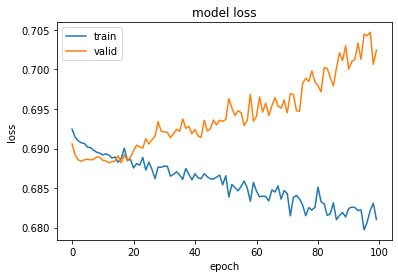

In [ ]:
import matplotlib.pyplot as plt
loss = train_history.history["loss"]
var_loss = train_history.history["val_loss"]
plt.plot(loss,label="loss")
plt.plot(var_loss,label="val_loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("model loss")
plt.legend(["train","valid"],loc = "upper left")

In [ ]:
predict_x = regressor.predict(X_test) 
df_predict = pd.DataFrame(predict_x,columns = ["Buy"])
df_predict["Action"] = np.where(df_predict["Buy"] > 0.5, 1, 0)
result = pure_df.loc['2015-01-01':,:].copy()
result["Predict"] = list(df_predict["Action"])
result

64/64 [==============================] - 0s 2ms/step


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Close_lag,Percent_Returns,Signal,...,Bear_Power,distance_to_minima,distance_to_maxima,vwap_ROC,true_range_ROC,RSI_ROC,ADXR_ROC,MACD_Hist_ROC,MACD_Hist_ROC_ROC,Predict
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02 00:00:00-05:00,2058.899902,2072.360107,2046.040039,2058.199951,2708700000,0.0,0.0,2020.579956,-0.018278,0,...,-22.229272,-27.550049,35.350098,0.199360,361.759541,-15.377185,-14.533221,-87.089142,-34.509342,0
2015-01-05 00:00:00-05:00,2054.439941,2054.439941,2017.339966,2020.579956,3799120000,0.0,0.0,2002.609985,-0.008893,0,...,-35.032894,-65.170044,72.970093,0.316755,341.671511,-33.749484,-7.154282,-165.386141,-3.526951,1
2015-01-06 00:00:00-05:00,2022.150024,2030.250000,1992.439941,2002.609985,4460110000,0.0,0.0,2025.900024,0.011630,1,...,-43.345293,-83.140015,90.940063,0.327573,384.741306,-40.253970,1.967567,-226.212235,-23.964826,1
2015-01-07 00:00:00-05:00,2005.550049,2029.609985,2005.550049,2025.900024,3805480000,0.0,0.0,2062.139893,0.017888,1,...,-26.940116,-59.849976,67.650024,0.602958,168.527248,-24.287894,10.838572,-256.241159,-138.226925,0
2015-01-08 00:00:00-05:00,2030.609985,2064.080078,2030.609985,2062.139893,3934010000,0.0,0.0,2044.810059,-0.008404,0,...,-11.763422,-23.610107,31.410156,0.742971,21.092356,3.323839,9.753157,-302.227123,1316.469831,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-30 00:00:00-05:00,3829.060059,3839.850098,3800.340088,3839.500000,2979870000,0.0,0.0,3824.139893,-0.004001,0,...,-34.262032,0.010010,50.320068,-0.951844,-55.491719,8.687454,-11.899983,-49.872190,-177.970230,0
2023-01-03 00:00:00-05:00,3853.290039,3878.459961,3794.330078,3824.139893,3959140000,0.0,0.0,3852.969971,0.007539,1,...,-36.784633,-15.350098,65.680176,-1.017569,72.432497,0.010871,-7.294625,-52.785724,-1628.446308,0
2023-01-04 00:00:00-05:00,3840.360107,3873.159912,3815.770020,3852.969971,4414080000,0.0,0.0,3808.100098,-0.011646,0,...,-22.629778,37.199951,25.489990,-1.239390,71.672180,10.285107,-4.196741,-67.972277,180.508389,0


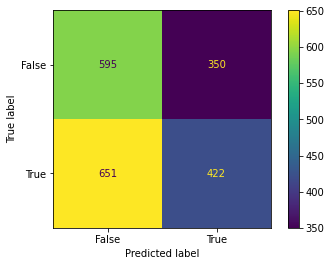

{'Accuracy': 0.5039643211100099, 'Precision': 0.5466321243523317, 'Sensitivity_recall': 0.3932898415657036, 'Specificity': 0.6296296296296297, 'F1_score': 0.4574525745257452}


array([[595, 350],
       [651, 422]])

In [ ]:
compute_confusion_matrix(train_test_split(y, '1982-01-01', '2015-01-01')[1], df_predict["Action"])

# Experimental

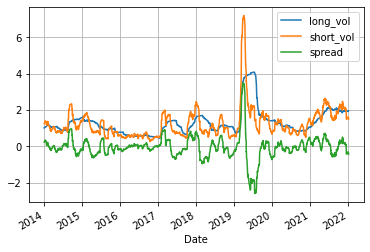

In [ ]:
res.long_vol.plot(grid=True, label="long_vol", legend=True)
res.short_vol.plot(grid=True, label="short_vol", legend=True)
res.short_long_vol_delta.plot(grid=True, label="spread", legend=True)

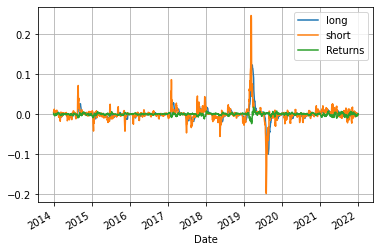

In [ ]:
res.long_vol_delta.plot(grid=True, label="long", legend=True)
res.short_vol_delta.plot(grid=True, label="short", legend=True)
res.MA12.plot(grid=True, label="Returns", legend=True)

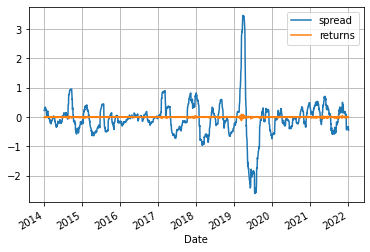

In [ ]:
res.short_long_vol_delta.plot(grid=True, label="spread", legend=True)
res.Percent_Returns.plot(grid=True, label="returns", legend=True)

In [ ]:
# Conducting ROC Analysis

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(res['Signal'], res['y_pred'])
fpr, tpr, thresholds = roc_curve(res['Signal'], res['y_pred'][:,1])

plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

KeyError: ignored

# Back Testing

In [ ]:
from backtesting import Backtest, Strategy
from backtesting.backtesting import plot

class Logit(Strategy):

    def init(self):
        pass

    def trader(self, postion_size):
             
        if self.data.smart_pred[-1] ==1:
            if not self.position.is_long:
              self.buy(size = postion_size)

        elif self.data.smart_pred[-1]==0: 
            if not self.position.is_short:
              self.sell(size = postion_size )     

    def next(self):
      current_signal = self.data.smart_pred[-1]
      position_closer = self.data.Postion_Closer[-1]
      long_vol_delta = self.data.long_vol_delta[-1]
      short_vol_delta = self.data.short_vol_delta[-1]
      long_vol = self.data.long_vol[-1]
      short_vol = self.data.short_vol[-1]
      vol_spread = self.data.short_long_vol_delta[-1]

      #self.trader(0.99)
      
      if abs(vol_spread) <0.05:
          self.position.close()

      elif abs(vol_spread) >0.05 and abs(vol_spread)<0.10: 
          if long_vol_delta >0:
            if short_vol_delta >0:
              self.trader(0.50)
            else:   
              self.trader(0.25)
          else:
            self.position.close()

      elif abs(vol_spread) >0.10 and abs(vol_spread)<0.125: 
          if long_vol_delta >0:
            if short_vol_delta >0:
              self.trader(0.50)
            else:   
              self.trader(0.950)
          else:
            self.position.close()

      elif abs(vol_spread) >0.125 and abs(vol_spread)<0.15:  
          if long_vol_delta >0:
            if short_vol_delta >0:
              self.trader(0.50)
            else:   
              self.trader(0.950)
          else:
            self.position.close()

      elif abs(vol_spread) >0.15 and abs(vol_spread)<0.20:  
          if long_vol_delta >0:
            if short_vol_delta >0:
              self.trader(0.50)
            else:   
              self.trader(0.950)
      else:
          if long_vol_delta >0:
            if short_vol_delta >0:
              self.trader(0.50)
            else:   
              self.trader(0.950)
          else:
            self.position.close()
           

           

bt = Backtest(res, Logit, cash=100000, commission=0.0002, exclusive_orders=True)

output = bt.run()
output

bt.plot()

Row(id='2069', ...)

In [ ]:
output

Start                     2015-01-02 00:00...
End                       2023-01-09 00:00...
Duration                   2929 days 00:00:00
Exposure Time [%]                   99.900941
Equity Final [$]                341420.219885
Equity Peak [$]                 353269.008403
Return [%]                          241.42022
Buy & Hold Return [%]               89.101651
Return (Ann.) [%]                   16.563372
Volatility (Ann.) [%]               20.305003
Sharpe Ratio                         0.815729
Sortino Ratio                        1.479883
Calmar Ratio                         0.840214
Max. Drawdown [%]                   -19.71329
Avg. Drawdown [%]                   -2.598523
Max. Drawdown Duration      456 days 00:00:00
Avg. Drawdown Duration       27 days 00:00:00
# Trades                                  437
Win Rate [%]                        56.292906
Best Trade [%]                      16.761496
Worst Trade [%]                     -8.704653
Avg. Trade [%]                    

# Confusion Matrix

In [ ]:
import matplotlib.pyplot as plt
from sklearn import metrics


def compute_confusion_matrix(actual, predicted): 
  #Displau and compute confusion matrix
  confusion_matrix = metrics.confusion_matrix(actual, predicted)
  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
  cm_display.plot()
  plt.show()
  # Compute relevant statistics
  Accuracy = metrics.accuracy_score(actual, predicted)
  Precision = metrics.precision_score(actual, predicted)
  Sensitivity_recall = metrics.recall_score(actual, predicted)
  Specificity = metrics.recall_score(actual, predicted, pos_label=0)
  F1_score = metrics.f1_score(actual, predicted)
  print({"Accuracy":Accuracy,"Precision":Precision,"Sensitivity_recall":Sensitivity_recall,"Specificity":Specificity,"F1_score":F1_score})
  return confusion_matrix

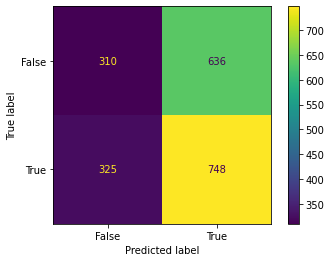

{'Accuracy': 0.5240217929668153, 'Precision': 0.5404624277456648, 'Sensitivity_recall': 0.6971109040074557, 'Specificity': 0.3276955602536998, 'F1_score': 0.6088726088726089}


array([[310, 636],
       [325, 748]])

In [ ]:
compute_confusion_matrix(res['Signal'], res['y_pred'])

In [ ]:
df.groupby(['Signal','y_pred'])['Percent_Returns'].mean()

In [ ]:
from google.colab import files

df.to_csv('output.csv', encoding = 'utf-8-sig') 
files.download('output.csv')

#   Kelly Criterion 

In [ ]:
def kelly_criterion(win_prob, win_amount, loss_amount):
    return (win_prob * (win_amount - loss_amount) - (1 - win_prob) * loss_amount) / loss_amount